# AI Explanations: Deploying an Explainable Image Model with Vertex AI 

## Overview

This lab shows how to train a classification model on image data and deploy it to Vertex AI to serve predictions with explanations (feature attributions). In this lab you will:
* Explore the dataset
* Build and train a custom image classification model with Vertex AI
* Deploy the model to an endpoint
* Serve predictions with explanations
* Visualize feature attributions from Integrated Gradients

## Setup

### Import libraries

Import the libraries for this tutorial.

In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [2]:
import base64
import random
from datetime import datetime
from io import BytesIO

import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from google.cloud import aiplatform
from matplotlib import pyplot as plt

2026-01-24 22:09:25.603044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769292565.648198    7971 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769292565.665738    7971 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-24 22:09:25.728058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jupyter/.local/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as 

In [3]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT
REGION = "us-central1"
GCS_PATTERN = "gs://asl-public/data/flowers-xai/*.tfrec"
DATA_PATH = f"gs://{BUCKET}/flowers/data"
OUTDIR = f"gs://{BUCKET}/flowers/model_{TIMESTAMP}"

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["DATA_PATH"] = DATA_PATH
os.environ["OUTDIR"] = OUTDIR
os.environ["TIMESTAMP"] = TIMESTAMP
print(f"Project: {PROJECT}")

Project: qwiklabs-gcp-02-3acc017430ec


Run the following cell to create your Cloud Storage bucket if it does not already exist.

In [4]:
%%bash
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
   echo -e "Bucket gs://${BUCKET} already exists."
    
else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} gs://${BUCKET}
   echo -e "\nHere are your current buckets:"
   gsutil ls
fi

Bucket gs://qwiklabs-gcp-02-3acc017430ec already exists.


## Explore the Dataset
The dataset used for this tutorial is the [flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). This section shows how to shuffle, split, and copy the files to your GCS bucket. 

### Load, split, and copy the dataset to your GCS bucket

In [5]:
TRAINING_DATA_PATH = DATA_PATH + "/training"
EVAL_DATA_PATH = DATA_PATH + "/validation"
VALIDATION_SPLIT = 0.2

# Split data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]

# Copy training files to GCS
for file in training_filenames:
    !gsutil -m cp $file $TRAINING_DATA_PATH/

# Copy eval files to GCS
for file in validation_filenames:
    !gsutil -m cp $file $EVAL_DATA_PATH/

Copying gs://asl-public/data/flowers-xai/flowers03-230.tfrec...
/ [1/1 files][  6.0 MiB/  6.0 MiB] 100% Done                                    
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://asl-public/data/flowers-xai/flowers12-230.tfrec...
/ [1/1 files][  6.0 MiB/  6.0 MiB] 100% Done                                    
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://asl-public/data/flowers-xai/flowers00-230.tfrec...
/ [1/1 files][  6.0 MiB/  6.0 MiB] 100% Done                                    
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://asl-public/data/flowers-xai/flowers01-230.tfrec...
/ [1/1 files][  5.9 MiB/  5.9 MiB] 100% Done                                    
Operation completed over 1 objects/5.9 MiB.                                      
Copying gs://asl-public/data/flowers-xai/flowers07-230.tfrec...
/ [1/1 files][  5.8 MiB/  5.

Run the following commands. You should see a number of .tfrec files in your GCS bucket at both gs://{BUCKET}/flowers/data/training and gs://{BUCKET}/flowers/data/validation

In [6]:
!gsutil ls -l $TRAINING_DATA_PATH

   6250983  2026-01-24T22:09:50Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/training/flowers00-230.tfrec
   6231074  2026-01-24T22:09:52Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/training/flowers01-230.tfrec
   5952336  2026-01-24T22:10:13Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/training/flowers02-230.tfrec
   6254378  2026-01-24T22:09:45Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/training/flowers03-230.tfrec
   6100076  2026-01-24T22:10:01Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/training/flowers05-230.tfrec
   6088244  2026-01-24T22:09:54Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/training/flowers07-230.tfrec
   6162742  2026-01-24T22:10:06Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/training/flowers08-230.tfrec
   6346261  2026-01-24T22:10:10Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/training/flowers09-230.tfrec
   6105472  2026-01-24T22:09:59Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/training/flowers11-230.tfrec
   6261871

In [7]:
!gsutil ls -l $EVAL_DATA_PATH

   6056727  2026-01-24T22:10:17Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/validation/flowers04-230.tfrec
   5968916  2026-01-24T22:10:15Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/validation/flowers06-230.tfrec
   5917130  2026-01-24T22:10:19Z  gs://qwiklabs-gcp-02-3acc017430ec/flowers/data/validation/flowers10-230.tfrec
TOTAL: 3 objects, 17942773 bytes (17.11 MiB)


### Create ingest functions and visualize some of the examples
Define and execute helper functions to plot the images and corresponding labels.

2026-01-24 22:10:31.772872: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2026-01-24 22:10:31.977338: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2026-01-24 22:10:32.154118: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


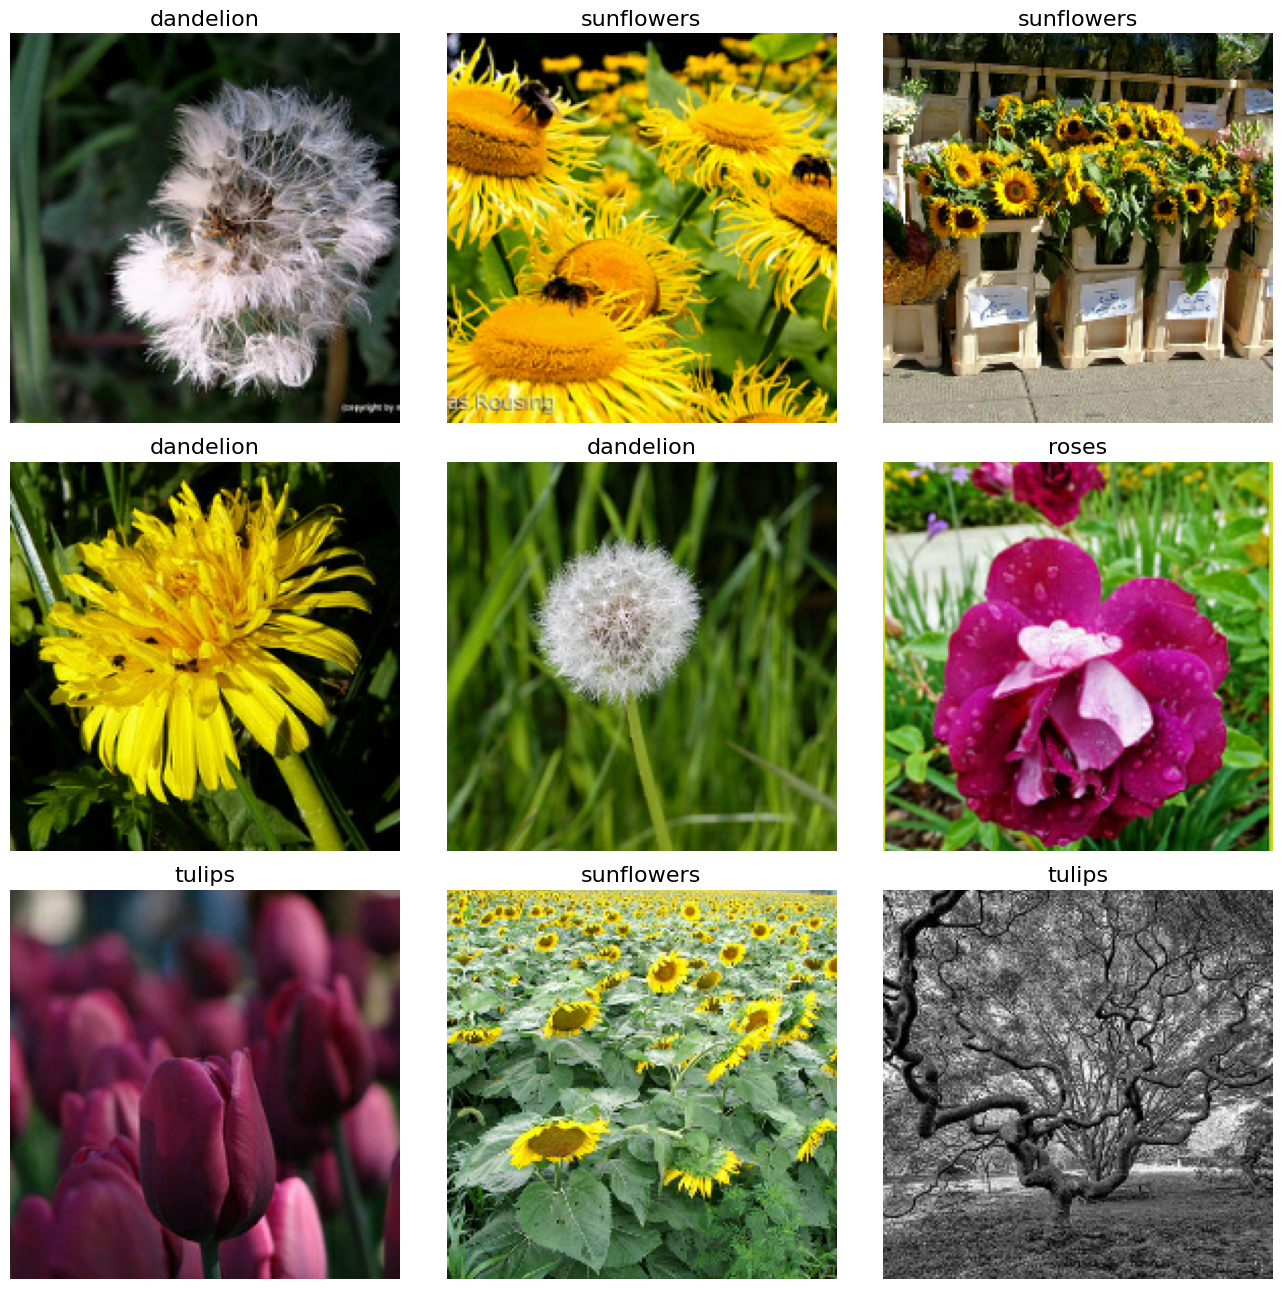

In [8]:
IMAGE_SIZE = [192, 192]
BATCH_SIZE = 32

# Do not change, maps to the labels in the data
CLASSES = [
    "daisy",
    "dandelion",
    "roses",
    "sunflowers",
    "tulips",
]


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature(
            [], tf.string
        ),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = (
        tf.cast(image, tf.float32) / 255.0
    )  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    one_hot_class = tf.sparse.to_dense(example["one_hot_class"])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class


# Load tfrecords into tf.data.Dataset
def load_dataset(gcs_pattern):
    filenames = tf.io.gfile.glob(gcs_pattern + "/*")
    ds = tf.data.TFRecordDataset(filenames).map(read_tfrecord)
    return ds


# Converts N examples in dataset to numpy arrays
def dataset_to_numpy(dataset, N):
    numpy_images = []
    numpy_labels = []

    for images, labels in dataset.take(N):
        numpy_images.append(images.numpy())
        numpy_labels.append(labels.numpy())

    return numpy_images, numpy_labels


def display_one_image(image, title, subplot):
    plt.subplot(subplot)
    plt.axis("off")
    plt.imshow(image)
    plt.title(title, fontsize=16)
    return subplot + 1


def display_9_images_from_dataset(dataset):
    subplot = 331
    plt.figure(figsize=(13, 13))
    images, labels = dataset_to_numpy(dataset, 9)
    for i, image in enumerate(images):
        title = CLASSES[np.argmax(labels[i], axis=-1)]
        subplot = display_one_image(image, title, subplot)
        if i >= 8:
            break

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Display 9 examples from the dataset
ds = load_dataset(gcs_pattern=TRAINING_DATA_PATH)
display_9_images_from_dataset(ds)

## Build training pipeline
In this section you will build an application with keras to train an image classification model on Vertex AI Custom Training. 

Create a directory for the training application and an __ init __.py file (this is required for a Python application but it can be empty).

In [9]:
%%bash 
mkdir -p flowers/trainer
touch flowers/trainer/__init__.py

### Create training application in train.py

This code contains the training logic. Here you build an application to ingest data from GCS and train an image classification model using [mobileNet](https://tfhub.dev/google/imagenet/mobilenet_v2_100_192/feature_vector/5) as a feature extractor, then sending it's output feature vector through a tf.keras.dense layer with 5 units and softmax activation (because there are 5 possible labels). Also, use the `fire` library which enables arguments to `train_and_evaluate` to be passed via the command line. 

In [10]:
%%writefile flowers/trainer/train.py
import datetime
import fire
import os
import tensorflow as tf
import tensorflow_hub as hub

IMAGE_SIZE = [192, 192]


def read_tfrecord(example):

    features = {
        "image": tf.io.FixedLenFeature(
            [], tf.string
        ),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = (
        tf.cast(image, tf.float32) / 255.0
    )  # convert image to floats in [0, 1] range
    image = tf.reshape(
        image, [*IMAGE_SIZE, 3]
    )
    one_hot_class = tf.sparse.to_dense(example["one_hot_class"])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class


def load_dataset(gcs_pattern, batch_size=32, training=True):
    filenames = tf.io.gfile.glob(gcs_pattern)
    ds = tf.data.TFRecordDataset(filenames).map(
        read_tfrecord).batch(batch_size)
    if training:
        return ds.repeat()
    else:
        return ds


def build_model():
    # MobileNet model for feature extraction
    mobilenet_v2 = 'https://tfhub.dev/google/imagenet/'\
        'mobilenet_v2_100_192/feature_vector/5'
    feature_extractor_layer = hub.KerasLayer(
        mobilenet_v2,
        input_shape=[*IMAGE_SIZE, 3],
        trainable=False
    )

    # Instantiate model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(5, activation="softmax")
    ])

    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model


def train_and_evaluate(train_data_path,
                       eval_data_path,
                       output_dir,
                       batch_size,
                       num_epochs,
                       train_examples):

    model = build_model()
    train_ds = load_dataset(gcs_pattern=train_data_path,
                            batch_size=batch_size)
    eval_ds = load_dataset(gcs_pattern=eval_data_path,
                           training=False)
    num_batches = batch_size * num_epochs
    steps_per_epoch = train_examples // num_batches

    history = model.fit(
        train_ds,
        validation_data=eval_ds,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=2,  # 0=silent, 1=progress bar, 2=one line per epoch
    )

    model.save(output_dir)

    print("Exported trained model to {}".format(output_dir))

if __name__ == "__main__":
    fire.Fire(train_and_evaluate)


Writing flowers/trainer/train.py


### Test training application locally 
It's always a good idea to test out a training application locally (with only a few training steps) to make sure the code runs as expected.

In [11]:
%%bash
OUTDIR_LOCAL=local_test_training
rm -rf ${OUTDIR_LOCAL}
export PYTHONPATH=${PYTHONPATH}:${PWD}/flowers
python3 -m trainer.train \
    --train_data_path=gs://${BUCKET}/flowers/data/training/*.tfrec \
    --eval_data_path=gs://${BUCKET}/flowers/data/validation/*.tfrec \
    --output_dir=${OUTDIR_LOCAL} \
    --batch_size=1 \
    --num_epochs=1 \
    --train_examples=10 

2026-01-24 22:10:51.590156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769292651.616158   14352 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769292651.625491   14352 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/jupyter/.local/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
2026-01-24 22:10:59.367380: E external/local_xla/xla/stream_executor/cud

10/10 - 12s - loss: 2.1393 - accuracy: 0.1000 - val_loss: 1.9812 - val_accuracy: 0.2348 - 12s/epoch - 1s/step
Exported trained model to local_test_training


## Package code as source distribution
Now that you have validated your model training code, we need to package our code as a source distribution in order to submit a custom training job to Vertex AI.

In [12]:
%%writefile flowers/setup.py
from setuptools import find_packages
from setuptools import setup

setup(
    name='flowers_trainer',
    version='0.1',
    packages=find_packages(),
    include_package_data=True,
    install_requires=['fire==0.4.0', 'tensorflow-hub==0.12.0'],
    description='Flowers image classifier training application.'
)

Writing flowers/setup.py


In [13]:
%%bash
cd flowers
python ./setup.py sdist --formats=gztar
cd ..

running sdist
running egg_info
creating flowers_trainer.egg-info
writing flowers_trainer.egg-info/PKG-INFO
writing dependency_links to flowers_trainer.egg-info/dependency_links.txt
writing requirements to flowers_trainer.egg-info/requires.txt
writing top-level names to flowers_trainer.egg-info/top_level.txt
writing manifest file 'flowers_trainer.egg-info/SOURCES.txt'
reading manifest file 'flowers_trainer.egg-info/SOURCES.txt'
writing manifest file 'flowers_trainer.egg-info/SOURCES.txt'


running check
creating flowers_trainer-0.1
creating flowers_trainer-0.1/flowers_trainer.egg-info
creating flowers_trainer-0.1/trainer
copying files to flowers_trainer-0.1...
copying setup.py -> flowers_trainer-0.1
copying flowers_trainer.egg-info/PKG-INFO -> flowers_trainer-0.1/flowers_trainer.egg-info
copying flowers_trainer.egg-info/SOURCES.txt -> flowers_trainer-0.1/flowers_trainer.egg-info
copying flowers_trainer.egg-info/dependency_links.txt -> flowers_trainer-0.1/flowers_trainer.egg-info
copying flowers_trainer.egg-info/requires.txt -> flowers_trainer-0.1/flowers_trainer.egg-info
copying flowers_trainer.egg-info/top_level.txt -> flowers_trainer-0.1/flowers_trainer.egg-info
copying trainer/__init__.py -> flowers_trainer-0.1/trainer
copying trainer/train.py -> flowers_trainer-0.1/trainer
copying flowers_trainer.egg-info/SOURCES.txt -> flowers_trainer-0.1/flowers_trainer.egg-info
Writing flowers_trainer-0.1/setup.cfg
creating dist
Creating tar archive
removing 'flowers_trainer-0.1' 

Store the package in GCS

In [14]:
%%bash
gsutil cp flowers/dist/flowers_trainer-0.1.tar.gz gs://${BUCKET}/flowers/

Copying file://flowers/dist/flowers_trainer-0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  2.0 KiB/  2.0 KiB]                                                
Operation completed over 1 objects/2.0 KiB.                                      


To submit to the Cloud we use [`gcloud custom-jobs create`](https://cloud.google.com/sdk/gcloud/reference/ai/custom-jobs/create) and simply specify some additional parameters for the Vertex AI Training Service:
- display-name: A unique identifier for the Cloud job. We usually append system time to ensure uniqueness
- region: Cloud region to train in. See [here](https://cloud.google.com/vertex-ai/docs/general/locations) for supported Vertex AI Training Service regions

You might have earlier seen `gcloud ai custom-jobs create` executed with the `worker pool spec` and pass-through Python arguments specified directly in the command call, here we will use a YAML file, this will make it easier to transition to hyperparameter tuning.

Through the `args:` argument we add in the passed-through arguments for our `task.py` file.

In [15]:
%%bash
JOB_NAME=flowers_${TIMESTAMP}

PYTHON_PACKAGE_URI=gs://${BUCKET}/flowers/flowers_trainer-0.1.tar.gz
PYTHON_PACKAGE_EXECUTOR_IMAGE_URI="us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-11.py310:latest"
PYTHON_MODULE=trainer.train

echo > ./config.yaml \
"workerPoolSpecs:
  machineSpec:
    machineType: n1-standard-8
  replicaCount: 1
  pythonPackageSpec:
    executorImageUri: $PYTHON_PACKAGE_EXECUTOR_IMAGE_URI
    packageUris: $PYTHON_PACKAGE_URI
    pythonModule: $PYTHON_MODULE
    args:
    - --train_data_path=gs://${BUCKET}/flowers/data/training/*.tfrec
    - --eval_data_path=gs://${BUCKET}/flowers/data/validation/*.tfrec
    - --output_dir=$OUTDIR
    - --num_epochs=15
    - --train_examples=15000
    - --batch_size=32
    "

gcloud ai custom-jobs create \
  --region=${REGION} \
  --display-name=$JOB_NAME \
  --config=config.yaml

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
CustomJob [projects/1037168682583/locations/us-central1/customJobs/7106641368306417664] is submitted successfully.

Your job is still active. You may view the status of your job with the command

  $ gcloud ai custom-jobs describe projects/1037168682583/locations/us-central1/customJobs/7106641368306417664

or continue streaming the logs with the command

  $ gcloud ai custom-jobs stream-logs projects/1037168682583/locations/us-central1/customJobs/7106641368306417664


**NOTE** Model training will take 5 minutes or so. You have to wait for training to finish before moving forward.

### Serving function for image data

To pass images to the prediction service, you encode the compressed (e.g., JPEG) image bytes into base 64 -- which makes the content safe from modification while transmitting binary data over the network. Since this deployed model expects input data as raw (uncompressed) bytes, you need to ensure that the base 64 encoded data gets converted back to raw bytes before it is passed as input to the deployed model.

To resolve this, define a serving function (`serving_fn`) and attach it to the model as a preprocessing step. Add a `@tf.function` decorator so the serving function is fused to the underlying model (instead of upstream on a CPU).

When you send a prediction or explanation request, the content of the request is base 64 decoded into a Tensorflow string (`tf.string`), which is passed to the serving function (`serving_fn`). The serving function preprocesses the `tf.string` into raw (uncompressed) numpy bytes (`preprocess_fn`) to match the input requirements of the model:
- `io.decode_jpeg`- Decompresses the JPG image which is returned as a Tensorflow tensor with three channels (RGB).
- `image.convert_image_dtype` - Changes integer pixel values to float 32.
- `image.resize` - Resizes the image to match the input shape for the model.
- `resized / 255.0` - Rescales (normalization) the pixel data between 0 and 1.

At this point, the data can be passed to the model (`m_call`).

#### XAI Signatures

When the serving function is saved back with the underlying model (`tf.saved_model.save`), you specify the input layer of the serving function as the signature `serving_default`.

For XAI image models, you need to save two additional signatures from the serving function:

- `xai_preprocess`: The preprocessing function in the serving function.
- `xai_model`: The concrete function for calling the model.

Load the model into memory. **NOTE** This directory will not exist if your model has not finished training. Please wait for training to complete before moving forward

In [16]:
local_model = tf.keras.models.load_model(OUTDIR)

NotFoundError: Error executing an HTTP request: HTTP response code 404 with body '<?xml version='1.0' encoding='UTF-8'?><Error><Code>NoSuchKey</Code><Message>The specified key does not exist.</Message><Details>No such object: qwiklabs-gcp-02-3acc017430ec/flowers/model_20260124220934</Details></Error>'
	 when reading gs://qwiklabs-gcp-02-3acc017430ec/flowers/model_20260124220934

In [17]:
local_model.summary()

NameError: name 'local_model' is not defined

In [18]:
CONCRETE_INPUT = "numpy_inputs"


def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(192, 192))
    return resized


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    decoded_images = tf.map_fn(
        _preprocess, bytes_inputs, dtype=tf.float32, back_prop=False
    )
    return {
        CONCRETE_INPUT: decoded_images
    }  # User needs to make sure the key matches model's input


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


# the function that sends data through the model itself and returns
# the output probabilities
m_call = tf.function(local_model.call).get_concrete_function(
    [
        tf.TensorSpec(
            shape=[None, 192, 192, 3], dtype=tf.float32, name=CONCRETE_INPUT
        )
    ]
)

tf.saved_model.save(
    local_model,
    OUTDIR,
    signatures={
        "serving_default": serving_fn,
        # Required for XAI
        "xai_preprocess": preprocess_fn,
        "xai_model": m_call,
    },
)

NameError: name 'local_model' is not defined

## Get the serving function signature

You can get the signatures of your model's input and output layers by reloading the model into memory, and querying it for the signatures corresponding to each layer.

When making a prediction request, you need to route the request to the serving function instead of the model, so you need to know the input layer name of the serving function -- which you will use later when you make a prediction request.

You also need to know the name of the serving function's input and output layer for constructing the explanation metadata -- which is discussed subsequently.

In [19]:
loaded = tf.saved_model.load(OUTDIR)

serving_input = list(
    loaded.signatures["serving_default"].structured_input_signature[1].keys()
)[0]
print("Serving function input:", serving_input)
serving_output = list(
    loaded.signatures["serving_default"].structured_outputs.keys()
)[0]
print("Serving function output:", serving_output)

input_name = local_model.input.name
print("Model input name:", input_name)
output_name = local_model.output.name
print("Model output name:", output_name)

OSError: SavedModel file does not exist at: gs://qwiklabs-gcp-02-3acc017430ec/flowers/model_20260124220934/{saved_model.pbtxt|saved_model.pb}

In [20]:
parameters = aiplatform.explain.ExplanationParameters(
    {"integrated_gradients_attribution": {"step_count": 50}}
)

## Upload the model

Next, upload your model to a `Model` resource using `Model.upload()` method, with the following parameters:

- `display_name`: The human readable name for the `Model` resource.
- `artifact`: The Cloud Storage location of the trained model artifacts.
- `serving_container_image_uri`: The serving container image.
- `sync`: Whether to execute the upload asynchronously or synchronously.
- `explanation_parameters`: Parameters to configure explaining for `Model`'s predictions.
- `explanation_metadata`: Metadata describing the `Model`'s input and output for explanation.

If the `upload()` method is run asynchronously, you can subsequently block until completion with the `wait()` method.

In [21]:
MODEL_NAME = "flower_classifier_v1"
INPUT_METADATA = {"input_tensor_name": CONCRETE_INPUT, "modality": "image"}
OUTPUT_METADATA = {"output_tensor_name": serving_output}

input_metadata = aiplatform.explain.ExplanationMetadata.InputMetadata(
    INPUT_METADATA
)
output_metadata = aiplatform.explain.ExplanationMetadata.OutputMetadata(
    OUTPUT_METADATA
)

metadata = aiplatform.explain.ExplanationMetadata(
    inputs={"image": input_metadata}, outputs={"class": output_metadata}
)

NameError: name 'serving_output' is not defined

**NOTE** This can take a few minutes to run. 

In [22]:
aiplatform.init(project=PROJECT, staging_bucket=BUCKET)
model = aiplatform.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=OUTDIR,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest",
    explanation_parameters=parameters,
    explanation_metadata=metadata,
    sync=False,
)

model.wait()

NameError: name 'metadata' is not defined

## Deploy the model

Next, deploy your model for online prediction. To deploy the model, you invoke the `deploy` method, with the following parameters:

- `deployed_model_display_name`: A human readable name for the deployed model.
- `traffic_split`: Percent of traffic at the endpoint that goes to this model, which is specified as a dictionary of one or more key/value pairs.
If only one model, then specify as { "0": 100 }, where "0" refers to this model being uploaded and 100 means 100% of the traffic.
If there are existing models on the endpoint, for which the traffic will be split, then use model_id to specify as { "0": percent, model_id: percent, ... }, where model_id is the model id of an existing model to the deployed endpoint. The percents must add up to 100.
- `machine_type`: The type of machine to use for training.
- `max_replica_count`: The maximum number of compute instances to scale to. In this tutorial, only one instance is provisioned.

**NOTE** This can take a few minutes.  

In [23]:
endpoint = model.deploy(
    deployed_model_display_name=MODEL_NAME,
    traffic_split={"0": 100},
    machine_type="n1-standard-4",
    min_replica_count=1,
    max_replica_count=1,
)

NameError: name 'model' is not defined

### Prepare the request content
You are going to send the flower image as compressed JPG image, instead of the raw uncompressed bytes:

- `mpimg.imsave`: Write the uncompressed image to disk as a compressed JPEG image.
- `tf.io.read_file`: Read the compressed JPG images back into memory as raw bytes.
- `base64.b64encode`: Encode the raw bytes into a base 64 encoded string.

In [24]:
eval_ds = load_dataset(EVAL_DATA_PATH)
x_test, y_test = dataset_to_numpy(eval_ds, 5)

# Single image from eval dataset
test_image = x_test[0]

# Write image out as jpg
mpimg.imsave("tmp.jpg", test_image)

2026-01-24 22:12:17.870471: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Read the JPG image and encode it with base64 to send to the model endpoint. Send the encoded image to the endpoint with `endpoint.explain`. Then you can parse the response for the prediction and explanation. Full documentation on endpoint.explain can be found [here](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/projects.locations.endpoints/explain).

In [25]:
# Read image and base64 encode
bytes = tf.io.read_file("tmp.jpg")
b64str = base64.b64encode(bytes.numpy()).decode("utf-8")

instances_list = [{serving_input: {"b64": b64str}}]

# Get prediction with explanation
response = endpoint.explain(instances_list)
print(response)

NameError: name 'serving_input' is not defined

### Visualize feature attributions from Integrated Gradients. 
Query the response to get predictions and feature attributions. Use Matplotlib to visualize.

In [26]:
import io
from io import BytesIO

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

CLASSES = [
    "daisy",
    "dandelion",
    "roses",
    "sunflowers",
    "tulips",
]

# Parse prediction
for prediction in response.predictions:
    label_index = np.argmax(prediction)
    class_name = CLASSES[label_index]
    confidence_score = prediction[label_index]
    print(
        "Predicted class: "
        + class_name
        + "\n"
        + "Confidence score: "
        + str(confidence_score)
    )

    image = base64.b64decode(b64str)
    image = BytesIO(image)
    img = mpimg.imread(image, format="JPG")

# Parse explanation
for explanation in response.explanations:
    attributions = dict(explanation.attributions[0].feature_attributions)
    xai_label_index = explanation.attributions[0].output_index[0]
    xai_class_name = CLASSES[xai_label_index]
    xai_b64str = attributions["image"]["b64_jpeg"]
    xai_image = base64.b64decode(xai_b64str)
    xai_image = io.BytesIO(xai_image)
    xai_img = mpimg.imread(xai_image, format="JPG")

# Plot image, feature attribution mask, and overlayed image
fig = plt.figure(figsize=(13, 18))
fig.add_subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(img)
fig.add_subplot(1, 3, 2)
plt.title("Feature Attribution Mask")
plt.imshow(xai_img)
fig.add_subplot(1, 3, 3)
plt.title("Overlayed Attribution Mask")
plt.imshow(img)
plt.imshow(xai_img, alpha=0.6)
plt.show()

NameError: name 'response' is not defined

## What's next?

To learn more about AI Explanations, check out the resources here.

* [Vertex AI Explanations documentation](https://cloud.google.com/vertex-ai/docs/explainable-ai)
* [Integrated gradients paper](https://arxiv.org/abs/1703.01365)
* [XRAI paper](https://arxiv.org/abs/1906.02825)